# MODELOS MAR:

- SUPERVISADOS: KNN, SVM
- NO SUPERVISADO: CLUSTERING GMM

In [42]:
# P
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [43]:
# Functions

# Conversion del dataFrame a tipo numeric
def convert_to_numeric(column):
    if column.dtype in ['object','category']:
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if not contains_letters :
            return pd.to_numeric(column, errors='coerce')
    return column

def discretizar_df_arboles_1(df, max_depth=40, n_bins=18, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc' or columna.name == 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado.apply(convert_to_numeric)

# Discretizar dataFrame y mostrar correlación respecto a la variable objetivo
def discretizar_df_arboles(df, imprimir="SI", max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc' or columna.name != 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
   # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas = df_discretizado.corrwith(df_discretizado['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

    if imprimir == "SI":
        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas)

    return df_discretizado


def escalado_dataFrame(df) :
    if df.empty:
        raise ValueError("El DataFrame está vacío, no se puede realizar el escalado.")

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Normalizar df_imputacion_iterativa
    df_normalized = df.select_dtypes(include=['number']).copy()  # Crear una copia del DataFrame original
    
    if not df_normalized.empty:
        df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)
    else :
        print("Esto está vacío")
    return df_normalized

def calcular_ganancia_informacion(df_features, target, imprimir = 'SI'):
    
    # Extraer las características de interés del DataFrame
    X_interest = df_features.values
    
    # Extraer la variable objetivo del DataFrame principal
    y = target.values
    
    # Calcular la Ganancia de Información utilizando Mutual Information
    information_gain = mutual_info_classif(X_interest, y, discrete_features=False, random_state=42, n_neighbors=7)
    
    # Crear un DataFrame para visualizar los resultados
    ig_results = pd.DataFrame({'Feature': df_features.columns, 'Information Gain': information_gain})
    
    # Ordenar los resultados por Ganancia de Información en orden descendente
    ig_results_sorted = ig_results.sort_values(by='Information Gain', ascending=False)

    if imprimir == "SI":
        print(ig_results_sorted)

# División del conjunto de datos en entrenamiento, validacion y test 


def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=None):
    """
    Divide un conjunto de datos en entrenamiento, validación y test.

    Args:
        X: Matriz de características.
        y: Vector de etiquetas.
        train_size: Porcentaje de datos para entrenamiento (por defecto: 0.6).
        val_size: Porcentaje de datos para validación (por defecto: 0.2).
        test_size: Porcentaje de datos para test (por defecto: 0.2).
        random_state: Semilla para la aleatorización (por defecto: None).

    Returns:
        Tuple: (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    assert train_size + val_size + test_size == 1.0, "La suma de train_size, val_size y test_size debe ser igual a 1.0"

    # Dividir los datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Calcular porcentaje respecto al tamaño original
    val_size_relative = val_size / (1.0 - test_size)

    # Dividir los datos de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_relative, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def mostrar_cross_validation(model, X_train, y_train):
    cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )
    print("Cross validation : ")
    print(f"Métricas validación cruzada: {cv_scores}")
    print(f"Média métricas de validación cruzada: {cv_scores.mean()}")
    print("")

def mostrar_score(X_train, y_train, model):
    score = round(model.score(X_train, y_train), 3)*100
    print(f"Tanto por ciento de acierto : {score} %")
    print("")

def mostrar_estadisticas(y_val, y_pred) :
    mse = round(mean_squared_error(y_val, y_pred),3)
    accuracy = round(accuracy_score(y_val, y_pred),3)
    precision = round(precision_score(y_val, y_pred),3)
    recall = round(recall_score(y_val, y_pred),3)
    f1 = round(f1_score(y_val, y_pred),3)
    conf_matrix = confusion_matrix(y_val, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Error cuadrático medio en el conjunto de validación:", mse)
    print("Matriz de Confusión :\n", conf_matrix)
    print("")

def mostrar_curva_ROC(y_val, y_pred) :
    fpr, tpr, _ = roc_curve(y_val, y_pred)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Plotear la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
from sklearn.metrics import classification_report

def evaluar_modelo(model, X_val, y_val, X_test, y_test):
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    print("Validation Metrics:")
    print(classification_report(y_val, y_pred_val))
    
    print("Test Metrics:")
    print(classification_report(y_test, y_pred_test))

# Evaluar el mejor modelo KNN
evaluar_modelo(grid_search_knn.best_estimator(), X_val_prep, y_val, X_test_prep, y_test)

# Evaluar el mejor modelo SVM
evaluar_modelo(grid_search_svm.best_estimator(), X_val_prep, y_val, X_test_prep, y_test)


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

## Cargar los datos

In [44]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/mar27/OneDrive/Documentos/CURSOS/DATA_SCIENCE_KSCHOOL/00_PROYECTO/GIT/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)


# Binarización "Tumor Type" 0 -> NO CANCER; 1 -> SI CANCER + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
#df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT ----- Datos limpios

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

''' INICIO - Verificacion del information gain'''
# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column, imprimir = "NO")

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
df_discretizado_full = discretizar_df_arboles(df_full, imprimir ="NO") # Columnas de este segundo enfoque guardadas en columnas_segundo_enfoque
df_discretizado_reduced = discretizar_df_arboles(df_reduced,imprimir ="NO")

''' FIN - Verificacion del information gain'''

## --- CHECKPOINT ----- Datos discretizados + Information gain
# TODO Una vez hechos los modelos, habrá que estudiar cómo influye el usar esta serie de variables en la predicción
columnas_segundo_enfoque = ['Tumor type','OPN (pg/ml)','IL-6 (pg/ml)','IL-8 (pg/ml)','HGF (pg/ml)','Prolactin (pg/ml)','Omega score','GDF15 (ng/ml)','CYFRA 21-1 (pg/ml)','Myeloperoxidase (ng/ml)','sEGFR (pg/ml)']
df_reduced_segundo_enfoque = df[columnas_segundo_enfoque].copy()

C:\Users\mar27\AppData\Local\Temp\ipykernel_3028\453263450.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_values[col], inplace=True)


In [45]:
''' Valores para X
1. df : entero, limpio, sin normalizar ni discretizar
2. df_reduced : reducido, limpio, sin normalizar ni discretizar
3. df_reduced_discretizado_escalated --> Acorde a la Tabla 1
4. df_discretizado_full.drop(columns=['Tumor type']) --> Acorde a la Figura S3 (usando todas las variables) discretizado con arbol de decisión
5. df_discretizado_reduced.drop(columns=['Tumor type']) --> Acorde a la Figura S3; discretizado con arbol de decisión
'''

y = df_reduced['Tumor type']
X = df_reduced.drop(columns='Tumor type')

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming df is your DataFrame and y is your target variable
df = df_reduced.drop(columns='Tumor type')
y = df_reduced['Tumor type']

# Define a pipeline combining the discretizer and your model (e.g., a random forest)
pipeline = Pipeline(steps=[('discretizer', KBinsDiscretizer(encode='ordinal')),
                           ('model', RandomForestClassifier())])

# Define the grid of parameters to search over
param_grid = {
    'discretizer__n_bins': range(2, 11),  # test number of bins from 2 to 10
    'model__n_estimators': [100, 200],  # example of another hyperparameter you could tune
}

# Initialize the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search
grid_search.fit(df, y)

# Print the best parameters
print(grid_search.best_params_)

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd


# Initialize the discretizer
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Fit and transform the data
df_discretized = discretizer.fit_transform(df)

# Convert back to DataFrame
df_discretized = pd.DataFrame(df_discretized, columns=df.columns)

print(df_discretized)

## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

#####
#####

# Datos: 
# y = df_reduced['Tumor type']
# X = df_reduced.drop(columns='Tumor type')
# df_reduced = reducido, limpio, sin normalizar ni discretizar
# preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols),
                    # ('onehot', OneHotEncoder(handle_unknown='ignore',......)

#####
#####

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', verbose=3)
grid_search_knn.fit(X_train_prep, y_train)

print("Best parameters for KNN: ", grid_search_knn.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.803 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.789 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.830 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.780 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.806 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.798 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.789 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.835 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.780 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.811 to

Accuracy: 0.786
Precision: 0.814
Recall: 0.772
F1-score: 0.793
Error cuadrático medio en el conjunto de validación: 0.214
Matriz de Confusión :
 [[137  34]
 [ 44 149]]



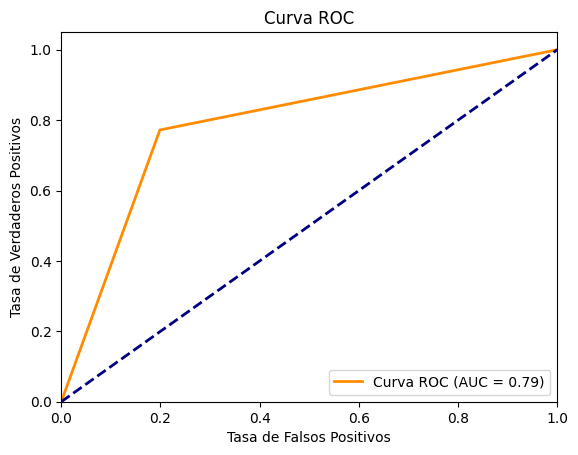

In [47]:
# Evaluación en el conjunto de validación
y_pred_val_knn = grid_search_knn.predict(X_val_prep)
mostrar_estadisticas(y_val, y_pred_val_knn)
mostrar_curva_ROC(y_val, y_pred_val_knn)


Accuracy: 0.794
Precision: 0.847
Recall: 0.758
F1-score: 0.8
Error cuadrático medio en el conjunto de validación: 0.206
Matriz de Confusión :
 [[139  27]
 [ 48 150]]



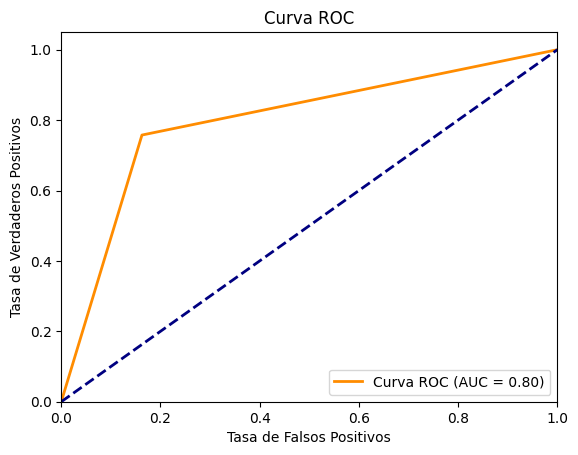

In [48]:

# Evaluación en el conjunto de prueba
y_pred_test_knn = grid_search_knn.predict(X_test_prep)
mostrar_estadisticas(y_test, y_pred_test_knn)
mostrar_curva_ROC(y_test, y_pred_test_knn)


## SVM

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Parámetros de búsqueda para SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', verbose=3)
grid_search_svm.fit(X_train_prep, y_train)

print("Best parameters for SVM: ", grid_search_svm.best_params_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.844 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.826 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.766 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.806 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

Accuracy: 0.821
Precision: 0.827
Recall: 0.839
F1-score: 0.833
Error cuadrático medio en el conjunto de validación: 0.179
Matriz de Confusión :
 [[137  34]
 [ 31 162]]



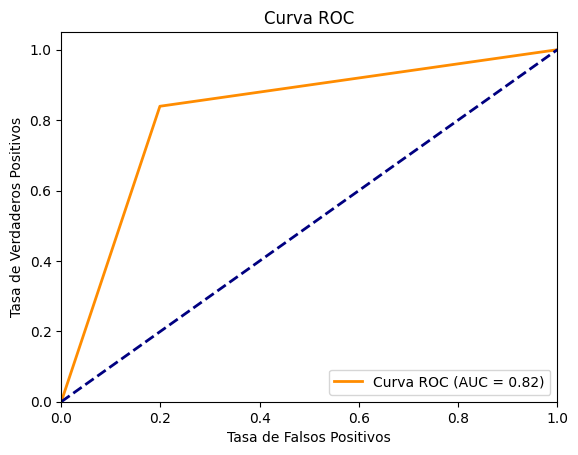

In [50]:

# Evaluación en el conjunto de validación
y_pred_val_svm = grid_search_svm.predict(X_val_prep)
mostrar_estadisticas(y_val, y_pred_val_svm)
mostrar_curva_ROC(y_val, y_pred_val_svm)


Accuracy: 0.821
Precision: 0.872
Recall: 0.788
F1-score: 0.828
Error cuadrático medio en el conjunto de validación: 0.179
Matriz de Confusión :
 [[143  23]
 [ 42 156]]



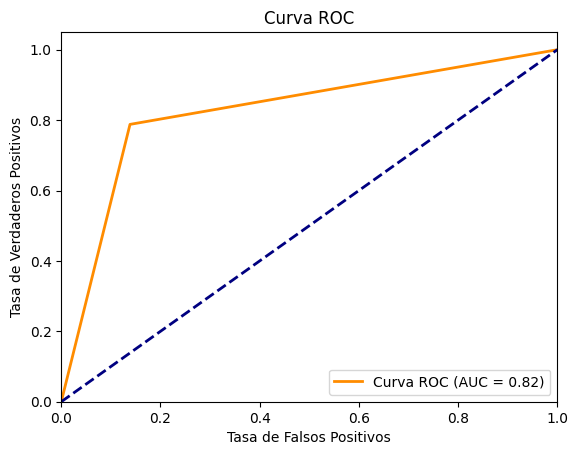

In [51]:

# Evaluación en el conjunto de prueba
y_pred_test_svm = grid_search_svm.predict(X_test_prep)
mostrar_estadisticas(y_test, y_pred_test_svm)
mostrar_curva_ROC(y_test, y_pred_test_svm)


Performance on validation set:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       171
           1       0.83      0.84      0.83       193

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.82      0.82      0.82       364

Accuracy: 0.821
Precision: 0.827
Recall: 0.839
F1-score: 0.833
Error cuadrático medio en el conjunto de validación: 0.179
Matriz de Confusión :
 [[137  34]
 [ 31 162]]

Your statistical function results:  None


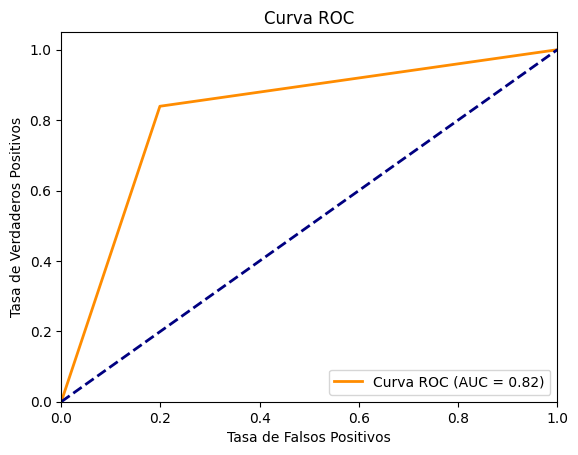

Performance on test set:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       166
           1       0.87      0.79      0.83       198

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.83      0.82      0.82       364

Accuracy: 0.821
Precision: 0.872
Recall: 0.788
F1-score: 0.828
Error cuadrático medio en el conjunto de validación: 0.179
Matriz de Confusión :
 [[143  23]
 [ 42 156]]

Your statistical function results:  None


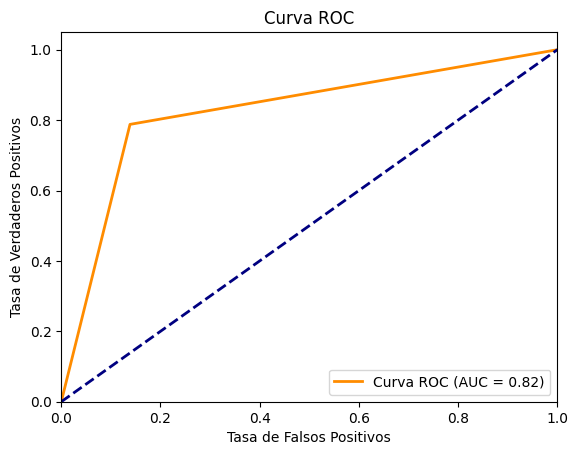

In [52]:
# Define a function to evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    # Replace the following line with your specific statistical functions
    print("Your statistical function results: ", mostrar_estadisticas(y, y_pred))
    mostrar_curva_ROC(y, y_pred)

# Evaluate the model on the validation set
print("Performance on validation set:")
evaluate_model(random_search_svm, X_val_prep, y_val)

# Evaluate the model on the test set
print("Performance on test set:")
evaluate_model(random_search_svm, X_test_prep, y_test)

## Clustering GMM

In [53]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, classification_report
)

# Function to calculate and display performance metrics
def calcular_métricas(y_val, y_pred):
    conf_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print("Matriz de Confusión :\n", conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print(classification_report(y_val, y_pred))

# Create an instance of the GMM clustering model
model_GMM = GaussianMixture(n_components=2, random_state=42)

# Check if the data is not null
if X_train_prep is not None and y_train is not None:
    # Train the model using the preprocessed training data
    model_GMM.fit(X_train_prep)

    # Predict on the validation set
    y_pred = model_GMM.predict(X_val_prep)

    # Calculate and display performance metrics
    calcular_métricas(y_val, y_pred)

    # Pipeline and GridSearch for optimization
    pipeline = Pipeline([
        ('gmm', GaussianMixture(random_state=42))
    ])

    param_grid = {
        'gmm__n_components': [1, 2, 3, 4, 5],
        'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_prep, y_train)

    # Improve model using the best hyperparameters
    print("Best parameters: ", grid_search.best_params_)

    # Use the best model to make predictions
    y_val_pred_gmm = grid_search.predict(X_val_prep)
    print("Fase de VALIDACIÓN estadísticas para GMM optimizado:")
    calcular_métricas(y_val, y_val_pred_gmm)

    y_test_pred_gmm = grid_search.predict(X_test_prep)
    print("Fase de TEST estadísticas para GMM optimizado:")
    calcular_métricas(y_test, y_test_pred_gmm)
else:
    print("Data is not available for model training.")

Matriz de Confusión :
 [[161  10]
 [ 97  96]]
Precision: 0.9056603773584906
Recall: 0.49740932642487046
F1-score: 0.6421404682274248
              precision    recall  f1-score   support

           0       0.62      0.94      0.75       171
           1       0.91      0.50      0.64       193

    accuracy                           0.71       364
   macro avg       0.76      0.72      0.70       364
weighted avg       0.77      0.71      0.69       364



c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

Best parameters:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Fase de VALIDACIÓN estadísticas para GMM optimizado:
Matriz de Confusión :
 [[169   2]
 [ 85 108]]
Precision: 0.9818181818181818
Recall: 0.5595854922279793
F1-score: 0.7128712871287128
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       171
           1       0.98      0.56      0.71       193

    accuracy                           0.76       364
   macro avg       0.82      0.77      0.75       364
weighted avg       0.83      0.76      0.75       364

Fase de TEST estadísticas para GMM optimizado:
Matriz de Confusión :
 [[161   5]
 [ 99  99]]
Precision: 0.9519230769230769
Recall: 0.5
F1-score: 0.6556291390728477
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       166
           1       0.95      0.50      0.66       198

    accuracy                           0.71       364
   macro avg       0.79   

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

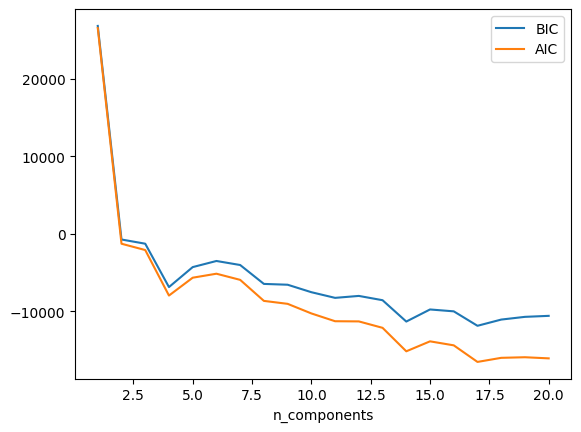

In [54]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

n_components = np.arange(1, 21)
models = [GaussianMixture(n, random_state=42).fit(X_train_prep)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_prep) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_prep) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

# Choose the model with the lowest BIC
best_gmm_model = models[np.argmin([m.bic(X_train_prep) for m in models])]

In [55]:
best_gmm_model = models[np.argmin([m.aic(X_train_prep) for m in models])]
best_gmm_model

GaussianMixture(n_components=17, random_state=42)

In [56]:
## n_components = 17

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, classification_report
)

# Function to calculate and display performance metrics
def calcular_métricas(y_val, y_pred):
    conf_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print("Matriz de Confusión :\n", conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print(classification_report(y_val, y_pred))

# Create an instance of the GMM clustering model
model_GMM = GaussianMixture(n_components=17, random_state=42)

# Check if the data is not null
if X_train_prep is not None and y_train is not None:
    # Train the model using the preprocessed training data
    model_GMM.fit(X_train_prep)

    # Predict on the validation set
    y_pred = model_GMM.predict(X_val_prep)

    # Calculate and display performance metrics
    calcular_métricas(y_val, y_pred)

    # Pipeline and GridSearch for optimization
    pipeline = Pipeline([
        ('gmm', GaussianMixture(random_state=42))
    ])

    param_grid = {
        'gmm__n_components': [1, 2, 3, 4, 5],
        'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_prep, y_train)

    # Improve model using the best hyperparameters
    print("Best parameters: ", grid_search.best_params_)

    # Use the best model to make predictions
    y_val_pred_gmm = grid_search.predict(X_val_prep)
    print("Fase de VALIDACIÓN estadísticas para GMM optimizado:")
    calcular_métricas(y_val, y_val_pred_gmm)

    y_test_pred_gmm = grid_search.predict(X_test_prep)
    print("Fase de TEST estadísticas para GMM optimizado:")
    calcular_métricas(y_test, y_test_pred_gmm)
else:
    print("Data is not available for model training.")

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Matriz de Confusión :
 [[74  1  0  0 30  7 49  0 10]
 [18 13  6 11 39 35 21 33 17]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]
Precision: 0.8702136372943826
Recall: 0.23901098901098902
F1-score: 0.33096066696661836
              precision    recall  f1-score   support

           0       0.80      0.43      0.56       171
           1       0.93      0.07      0.13       193
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

    accuracy                           0.24       364
   macro avg       0.1

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

Best parameters:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Fase de VALIDACIÓN estadísticas para GMM optimizado:
Matriz de Confusión :
 [[169   2]
 [ 85 108]]
Precision: 0.8331497242914566
Recall: 0.760989010989011
F1-score: 0.7515919025645291
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       171
           1       0.98      0.56      0.71       193

    accuracy                           0.76       364
   macro avg       0.82      0.77      0.75       364
weighted avg       0.83      0.76      0.75       364

Fase de TEST estadísticas para GMM optimizado:
Matriz de Confusión :
 [[161   5]
 [ 99  99]]
Precision: 0.8002007607776839
Recall: 0.7142857142857143
F1-score: 0.7013427141213728
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       166
           1       0.95      0.50      0.66       198

    accuracy                           0.71       364
   macro avg

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

In [57]:
## n_components = 4

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, classification_report
)

# Function to calculate and display performance metrics
def calcular_métricas(y_val, y_pred):
    conf_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print("Matriz de Confusión :\n", conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print(classification_report(y_val, y_pred))

# Create an instance of the GMM clustering model
model_GMM = GaussianMixture(n_components=4, random_state=42)

# Check if the data is not null
if X_train_prep is not None and y_train is not None:
    # Train the model using the preprocessed training data
    model_GMM.fit(X_train_prep)

    # Predict on the validation set
    y_pred = model_GMM.predict(X_val_prep)

    # Calculate and display performance metrics
    calcular_métricas(y_val, y_pred)

    # Pipeline and GridSearch for optimization
    pipeline = Pipeline([
        ('gmm', GaussianMixture(random_state=42))
    ])

    param_grid = {
        'gmm__n_components': [1, 2, 3, 4, 5],
        'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_prep, y_train)

    # Improve model using the best hyperparameters
    print("Best parameters: ", grid_search.best_params_)

    # Use the best model to make predictions
    y_val_pred_gmm = grid_search.predict(X_val_prep)
    print("Fase de VALIDACIÓN estadísticas para GMM optimizado:")
    calcular_métricas(y_val, y_val_pred_gmm)

    y_test_pred_gmm = grid_search.predict(X_test_prep)
    print("Fase de TEST estadísticas para GMM optimizado:")
    calcular_métricas(y_test, y_test_pred_gmm)
else:
    print("Data is not available for model training.")

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Matriz de Confusión :
 [[126   0  45]
 [ 51  55  87]
 [  0   0   0]]
Precision: 0.8646395976904451
Recall: 0.49725274725274726
F1-score: 0.5753638047158626
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       171
           1       1.00      0.28      0.44       193
           3       0.00      0.00      0.00         0

    accuracy                           0.50       364
   macro avg       0.57      0.34      0.39       364
weighted avg       0.86      0.50      0.58       364



c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

Best parameters:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Fase de VALIDACIÓN estadísticas para GMM optimizado:
Matriz de Confusión :
 [[169   2]
 [ 85 108]]
Precision: 0.8331497242914566
Recall: 0.760989010989011
F1-score: 0.7515919025645291
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       171
           1       0.98      0.56      0.71       193

    accuracy                           0.76       364
   macro avg       0.82      0.77      0.75       364
weighted avg       0.83      0.76      0.75       364

Fase de TEST estadísticas para GMM optimizado:
Matriz de Confusión :
 [[161   5]
 [ 99  99]]
Precision: 0.8002007607776839
Recall: 0.7142857142857143
F1-score: 0.7013427141213728
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       166
           1       0.95      0.50      0.66       198

    accuracy                           0.71       364
   macro avg

c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\mar27\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_